<a href="https://colab.research.google.com/github/gooran/kasreh-ezafeh/blob/main/eval_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!git clone https://github.com/HLTT14/NLP-Assignments.git

Cloning into 'NLP-Assignments'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 102 (delta 50), reused 12 (delta 3), pack-reused 0
Receiving objects: 100% (102/102), 21.56 MiB | 9.06 MiB/s, done.
Resolving deltas: 100% (50/50), done.


In [3]:
!unzip -o -q /content/NLP-Assignments/Assignment2/train.zip

# Setup

In [4]:
# import necessary libraries
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd

from matplotlib import pyplot as plt

import seaborn as sns

from gensim.models import KeyedVectors

from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.losses import BinaryCrossentropy

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Configuration


In [5]:
# Path to the data txt file on disk.
data_path = "/content/train.data"

# Prepare the data

In [6]:
df = pd.read_fwf(data_path, header = None, names=['word'],skip_blank_lines=False)

In [7]:
df = df.replace(np.nan, '', regex=True)

In [8]:
df.head()

,word
0,# gen_negative
1,منبع gen_negative
2,: gen_negative
3,) gen_negative
4,مجلة gen_positive


In [9]:
df['tag'] = df.apply(lambda row: '1' if 'gen_negative' in row.word.split() else '2', axis = 1)

In [10]:
df['word'] = df.apply(lambda row: row.word.replace('gen_negative', '').replace('gen_positive', '').strip(), axis = 1)

In [11]:
X = [] # store input sequence
Y = [] # store output sequence
X_sentence = []
Y_sentence = []
for index, row in df.iterrows():
  if(row.word!=''):
    X_sentence.append(row.word)
    Y_sentence.append(row.tag)
  else:
    X.append(X_sentence)
    Y.append(Y_sentence)
    X_sentence = []
    Y_sentence = []

In [12]:
num_words = len(set([word.lower() for sentence in X for word in sentence]))
num_tags   = len(set([word.lower() for sentence in Y for word in sentence]))

In [13]:
print("Total number of tagged sentences: {}".format(len(X)))
print("Vocabulary size: {}".format(num_words))
print("Total number of tags: {}".format(num_tags))

Total number of tagged sentences: 70103
Vocabulary size: 58315
Total number of tags: 2


In [14]:
# let's look at first data point
# this is one data point that will be fed to the RNN
print('sample X: ', X[0], '\n')
print('sample Y: ', Y[0], '\n')

sample X:  ['#', 'منبع', ':', ')', 'مجلة', 'سروش', 'هفتگی', '،', 'مصاحبه', 'با', 'رئیس', 'دفتر', 'الجزیره', 'در', 'تهران', '،', 'یک', 'هزار', 'و', 'سیصد', 'و', 'هشتاد', '(', '#', '#', 'الجزیره', 'هیچ', 'ارتباط', 'خاصی', 'با', 'طالبان', 'ندارد', '.'] 

sample Y:  ['1', '1', '1', '1', '2', '2', '1', '1', '1', '1', '2', '2', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '2', '1', '1', '1', '1', '1'] 



In [15]:
# In this many-to-many problem, the length of each input and output sequence must be the same.
# Since each word is tagged, it's important to make sure that the length of input sequence equals the output sequence
print("Length of first input sequence  : {}".format(len(X[0])))
print("Length of first output sequence : {}".format(len(Y[0])))

Length of first input sequence  : 33
Length of first output sequence : 33


# Vectorise X and Y
Encode X and Y to integer values

We'll use the Tokenizer() function from Keras library to encode text sequence to integer sequence

In [16]:
# encode X

word_tokenizer = Tokenizer()                      # instantiate tokeniser
word_tokenizer.fit_on_texts(X)                    # fit tokeniser on data
X_encoded = word_tokenizer.texts_to_sequences(X)  # use the tokeniser to encode input sequence

In [17]:
# encode Y

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
Y_encoded = tag_tokenizer.texts_to_sequences(Y)

In [18]:
# look at first encoded data point

print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', X[0], '\n')
print('Y: ', Y[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_encoded[0], '\n')
print('Y: ', Y_encoded[0], '\n')

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['#', 'منبع', ':', ')', 'مجلة', 'سروش', 'هفتگی', '،', 'مصاحبه', 'با', 'رئیس', 'دفتر', 'الجزیره', 'در', 'تهران', '،', 'یک', 'هزار', 'و', 'سیصد', 'و', 'هشتاد', '(', '#', '#', 'الجزیره', 'هیچ', 'ارتباط', 'خاصی', 'با', 'طالبان', 'ندارد', '.'] 

Y:  ['1', '1', '1', '1', '2', '2', '1', '1', '1', '1', '2', '2', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '2', '1', '1', '1', '1', '1'] 


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [30, 668, 12, 43, 1333, 1543, 1585, 3, 1607, 11, 171, 526, 1740, 4, 88, 3, 13, 33, 1, 140, 1, 179, 39, 30, 30, 1740, 92, 413, 640, 11, 4360, 243, 2] 

Y:  [1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1] 



In [19]:
# make sure that each sequence of input and output is same length

different_length = [1 if len(input) != len(output) else 0 for input, output in zip(X_encoded, Y_encoded)]
print("{} sentences have disparate input-output lengths.".format(sum(different_length)))

0 sentences have disparate input-output lengths.


## Pad sequences
The next step after encoding the data is to define the sequence lengths. As of now, the sentences present in the data are of various lengths. We need to either pad short sentences or truncate long sentences to a fixed length. This fixed length, however, is a hyperparameter.

In [20]:
# check length of longest sentence
lengths = [len(seq) for seq in X_encoded]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 1146


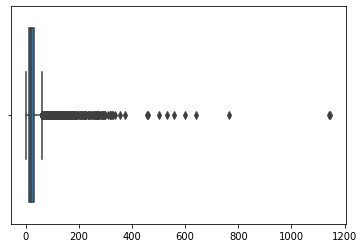

In [21]:
sns.boxplot(lengths)
plt.show()

In [22]:
# Pad each sequence to MAX_SEQ_LENGTH using KERAS' pad_sequences() function. 
# Sentences longer than MAX_SEQ_LENGTH are truncated.
# Sentences shorter than MAX_SEQ_LENGTH are padded with zeroes.

# Truncation and padding can either be 'pre' or 'post'. 
# For padding we are using 'pre' padding type, that is, add zeroes on the left side.
# For truncation, we are using 'post', that is, truncate a sentence from right side.

MAX_SEQ_LENGTH = 100  # sequences greater than 100 in length will be truncated

X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [23]:
# print the first sequence
print(X_padded[0], "\n"*3)
print(Y_padded[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0   30  668   12
   43 1333 1543 1585    3 1607   11  171  526 1740    4   88    3   13
   33    1  140    1  179   39   30   30 1740   92  413  640   11 4360
  243    2] 



[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 1
 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1]


RNN will learn the zero to zero mapping while training. So we don't need to worry about the padded zeroes. Please note that zero is not reserved for any word or tag, it's only reserved for padding.

In [24]:
# assign padded sequences to X and Y
X, Y = X_padded, Y_padded

## Loading the model

In [25]:
final_model = keras.models.load_model('/content/drive/MyDrive/final_model.h5')

In [26]:
# check summary of model
final_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 200)          11663200  
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 128)          135680    
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 40)           5160      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 1)            41        
Total params: 11,804,081
Trainable params: 135,721
Non-trainable params: 11,668,360
_________________________________________________________________


In [27]:
final_model.compile(loss=BinaryCrossentropy(),
              optimizer='adam',
              metrics=[keras.metrics.Precision(), keras.metrics.Recall()])

## Load Test Data

In [31]:
X_test, Y_test = X, Y

# Final Model evaluation

In [32]:
loss, precision, recall = final_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nPrecision: {1},\nRecall: {2}".format(loss, precision, recall))

2191/2191 [==============================] - 14s 6ms/step - loss: -0.7648 - precision: 1.0000 - recall: 0.9999
Loss: -0.7648122310638428,
Precision: 0.9999952912330627,
Recall: 0.9998936653137207
